# Tara PCA

In [1]:
# imports
from importlib import reload
import numpy as np
import pandas
import datetime

from matplotlib import pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy

import seaborn as sns

from oceancolor.tara import io
from oceancolor.tara import spectra

from sklearn import decomposition

from wpca import WPCA

# Load the Table

In [2]:
tara_db = io.load_tara_db()

# Rebin the Spectra

In [3]:
wv_nm, all_a_ph, all_a_ph_sig = spectra.spectra_from_table(tara_db)

In [31]:
reload(spectra)
wv_grid = np.arange(402.5, 707.5, 5.)
rwv_nm, r_aph, r_sig = spectra.rebin_to_grid(wv_nm, all_a_ph, all_a_ph_sig, wv_grid)

/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:248: RuntimeWarning: invalid value encountered in divide
  isum = np.nansum(values[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)
/home/xavier/Projects/Oceanography/python/ocean-color/oceancolor/tara/spectra.py:249: RuntimeWarning: invalid value encountered in divide
  esum = np.nansum(err_vals[gd]*mask[gd], axis=0) / np.sum(mask[gd],axis=0)


# PCA me

## Reverse for PCA

In [32]:
r_aph = r_aph.T
r_sig = r_sig.T
r_aph.shape

(302779, 60)

## Deal with Nan

In [33]:
bad = np.isnan(r_aph) | (r_sig <= 0.)
np.sum(bad)

24847

In [21]:
ii = np.where(bad)
bad_wv = rwv_nm[ii[1]]
bad_wv

array([405., 405., 405., ..., 415., 410., 415.])

## Mean

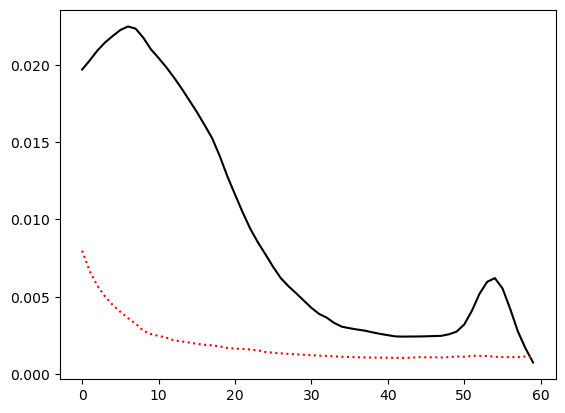

In [34]:
mean_spec = np.nanmean(r_aph, axis=0)
mean_sig = np.nanmean(r_sig, axis=0)
#
plt.clf()
ax = plt.gca()
ax.plot(mean_spec, 'k')
ax.plot(mean_sig, 'r:')
plt.show()

In [35]:
# Replace
r_aph[bad] = 0.
r_sig[bad] = 1e5

## Fit

In [50]:
pca_fit = decomposition.PCA(n_components=r_aph.shape[1]).fit(r_aph)

## Variance

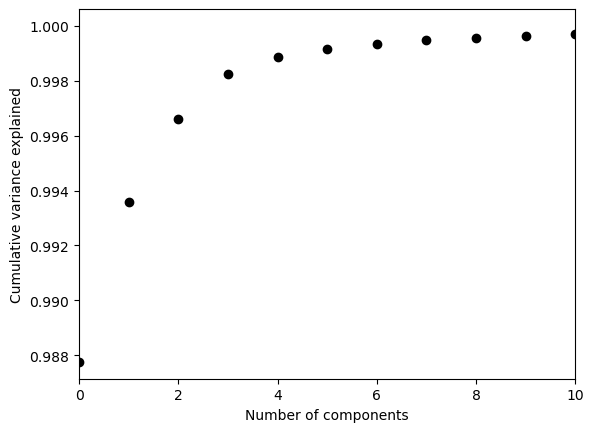

In [51]:
plt.clf()
ax = plt.gca()
ax.plot(np.cumsum(pca_fit.explained_variance_ratio_), 'ok')
# Label
ax.set_ylabel('Cumulative variance explained')
ax.set_xlabel('Number of components')
#
ax.set_xlim(0,10.)
#
plt.show()

## Eigenvectors

In [25]:
M = pca_fit.components_

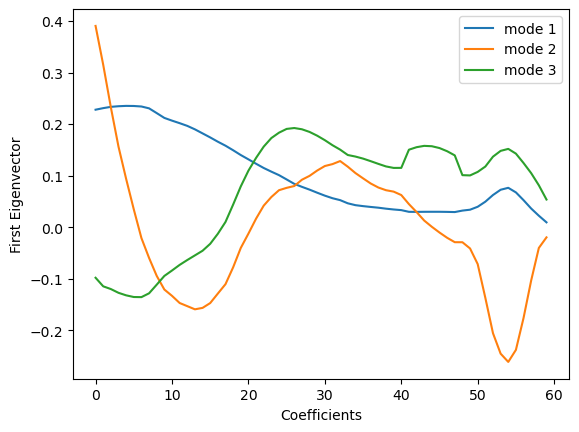

In [27]:
plt.clf()
ax = plt.gca()
ax.plot(M[0], label='mode 1')
ax.plot(M[1], label='mode 2')
ax.plot(M[2], label='mode 3')
#
ax.set_xlabel('Coefficients')
ax.set_ylabel('First Eigenvector')
ax.legend()
#
plt.show()

----

# Normalized

In [28]:
tot_aph = np.sum(r_aph, axis=1)
tot_aph.shape

(302779,)

In [30]:
norm_aph = r_aph / np.outer(tot_aph, np.ones(r_aph.shape[1]))

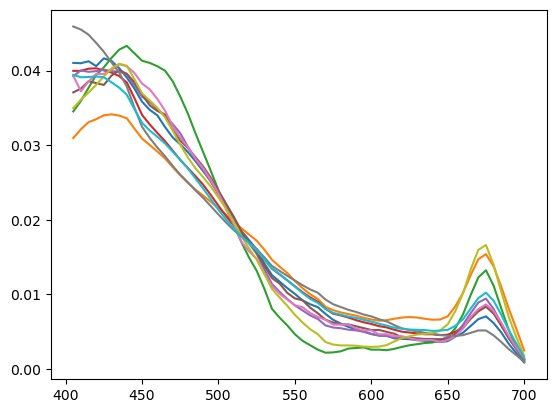

In [31]:
plt.clf()
ax = plt.gca()
#
for ii in range(10):
    ax.plot(rwv_nm, norm_aph[ii*1000,:])
plt.show()

# PCA

In [32]:
pca_fit_norm = decomposition.PCA(n_components=norm_aph.shape[1]).fit(norm_aph)

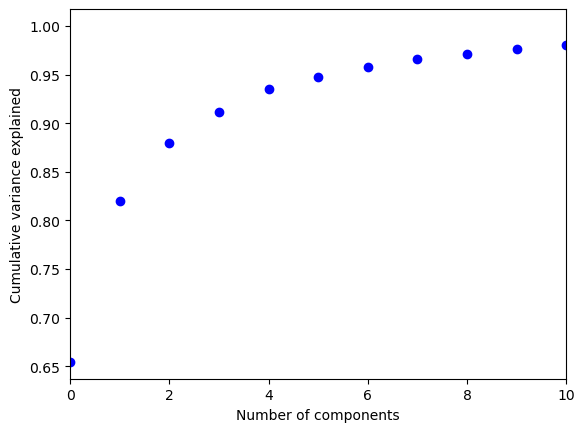

In [33]:
plt.clf()
ax = plt.gca()
ax.plot(np.cumsum(pca_fit_norm.explained_variance_ratio_), 'ob')
# Label
ax.set_ylabel('Cumulative variance explained')
ax.set_xlabel('Number of components')
#
ax.set_xlim(0,10.)
#
plt.show()

In [34]:
M_norm = pca_fit_norm.components_

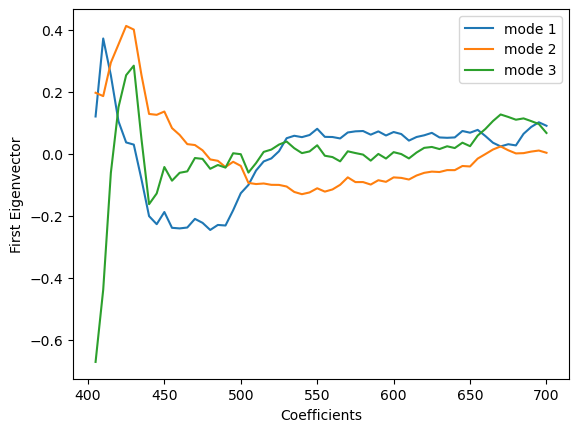

In [36]:
plt.clf()
ax = plt.gca()
ax.plot(rwv_nm, M_norm[0], label='mode 1')
ax.plot(rwv_nm, M_norm[1], label='mode 2')
ax.plot(rwv_nm, M_norm[2], label='mode 3')
#
ax.set_xlabel('Coefficients')
ax.set_ylabel('First Eigenvector')
ax.legend()
#
plt.show()

----

# Weighted PCA

## Weighted by reported error

In [36]:
r_sig.min()

5e-05

In [37]:
w_pca = WPCA(n_components=10).fit(r_aph, weights=1./r_sig)

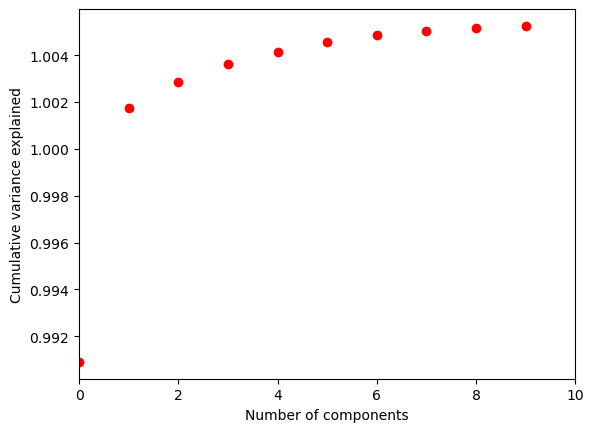

In [38]:
plt.clf()
ax = plt.gca()
ax.plot(np.cumsum(w_pca.explained_variance_ratio_), 'or')
# Label
ax.set_ylabel('Cumulative variance explained')
ax.set_xlabel('Number of components')
#
ax.set_xlim(0,10.)
#
plt.show()

In [39]:
M_wpca = w_pca.components_

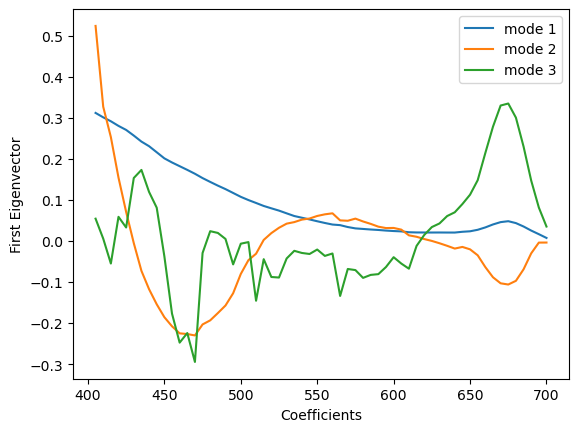

In [41]:
plt.clf()
ax = plt.gca()
ax.plot(rwv_nm, -1*M_wpca[0], label='mode 1')
ax.plot(rwv_nm, -1*M_wpca[1], label='mode 2')
ax.plot(rwv_nm, -1*M_wpca[2], label='mode 3')
#
ax.set_xlabel('Coefficients')
ax.set_ylabel('First Eigenvector')
ax.legend()
#
plt.show()

## Weighted by variance in the spectra

In [46]:
rms_ap = np.outer(np.ones(r_aph.shape[0]), np.std(r_aph, axis=0))
rms_ap.shape

(302779, 60)

In [54]:
rms_ap[0,:]

array([0.0314587 , 0.03173888, 0.03199801, 0.03210045, 0.03215848,
       0.03211495, 0.03197136, 0.0314833 , 0.0302302 , 0.0289642 ,
       0.02825017, 0.02758889, 0.02688039, 0.02596739, 0.02490504,
       0.02383157, 0.02268679, 0.02162553, 0.02040038, 0.01912399,
       0.01799081, 0.0168386 , 0.01573643, 0.01478621, 0.01388126,
       0.01275251, 0.01160255, 0.01083281, 0.01010638, 0.00931326,
       0.00855535, 0.00788564, 0.00739932, 0.00655211, 0.00604131,
       0.00577077, 0.00553838, 0.00532779, 0.00506266, 0.00484608,
       0.00466861, 0.00442183, 0.00438813, 0.00440498, 0.00440751,
       0.00440162, 0.0043674 , 0.00431341, 0.00449445, 0.00474519,
       0.00557431, 0.00704192, 0.00896749, 0.01043277, 0.01096625,
       0.00970574, 0.00752709, 0.00519427, 0.00319597, 0.00143802])

In [47]:
w_pca_d = WPCA(n_components=10).fit(r_aph, weights=1./rms_ap)

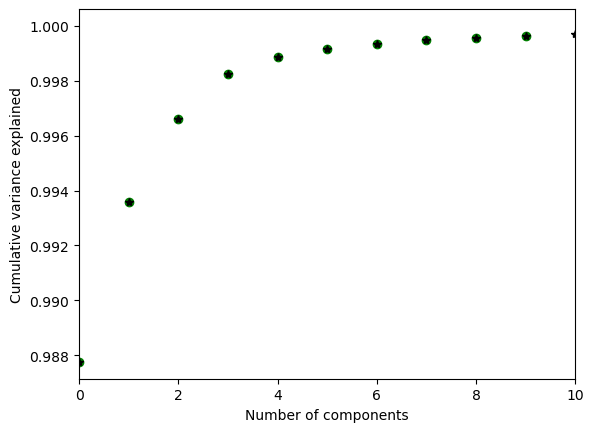

In [53]:
plt.clf()
ax = plt.gca()
ax.plot(np.cumsum(w_pca_d.explained_variance_ratio_), 'og')
ax.plot(np.cumsum(pca_fit.explained_variance_ratio_), '*k')
# Label
ax.set_ylabel('Cumulative variance explained')
ax.set_xlabel('Number of components')
#
ax.set_xlim(0,10.)
#
plt.show()